# Celestial Mechanics - Homework 5
## Giacomo Menegatti - 2122852

In [201]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import newton
from math import factorial as fac
import matplotlib.cm as cmaps


## Initial conditions

In [202]:
R0 = np.array([-267733.084163, 199426.194677, 254709.414665]) # I use the upper case to indicate a vector
V0 = np.array([4.168950, -2.598877, -3.925639])
GM = 324859.2139518842890 


## Stumff's functions
The general form of a Stumff's function is $$c_n(z)=\sum_{k=0}^\infty (-1)^k\frac{z^k}{(2k+n)!} $$ that far from zero can be derived from a combination of trigonometric functions in the positive domain and hyperbolic ones in the negative part. Around zero, to avoid errors in the computation, the series expansion is used. 

The first derivative is found applying the recursive relation $$ c'_{n}(z)=\frac{n}{2}c_{n+2}(z)-\frac{1}{2}c_{n+1}(z) $$

After studying where the computation starts to get unstable, I chosed $|z|<10^{-2}$ as a treshold for switching to the series computation, and considering that the precision is up to 15 digits in Python doubles, an expansion to $z^8$ is required.

In [203]:
pos_func = [lambda x: np.cos(x), lambda x: np.sin(x)/x, lambda x: (1-np.cos(x))/x**2, lambda x: (x-np.sin(x))/x**3, lambda x: (np.cos(x)-1+x**2/2)/x**4, lambda x: (np.sin(x)-x+x**3/6)/x**5]

neg_func = [lambda x: np.cosh(x), lambda x: np.sinh(x)/x, lambda x: (np.cosh(x)-1)/x**2, lambda x: (np.sinh(x)-x)/x**3, lambda x: (np.cosh(x)-1-x**2/2)/x**4, lambda x: (np.sinh(x)-x-x**3/6)/x**5]

def c(z, n=0):
  if np.abs(z)<1e-2:
    return sum((-z)**k/fac(2*k+n) for k in range(0, 8))
  elif z>0:
    return pos_func[n]((z)**0.5)
  else:
    return neg_func[n]((-z)**0.5)

def c_prime(z, n=0):
  return n/2*c(z, n=n+2)-1/2*c(z, n=n+1)


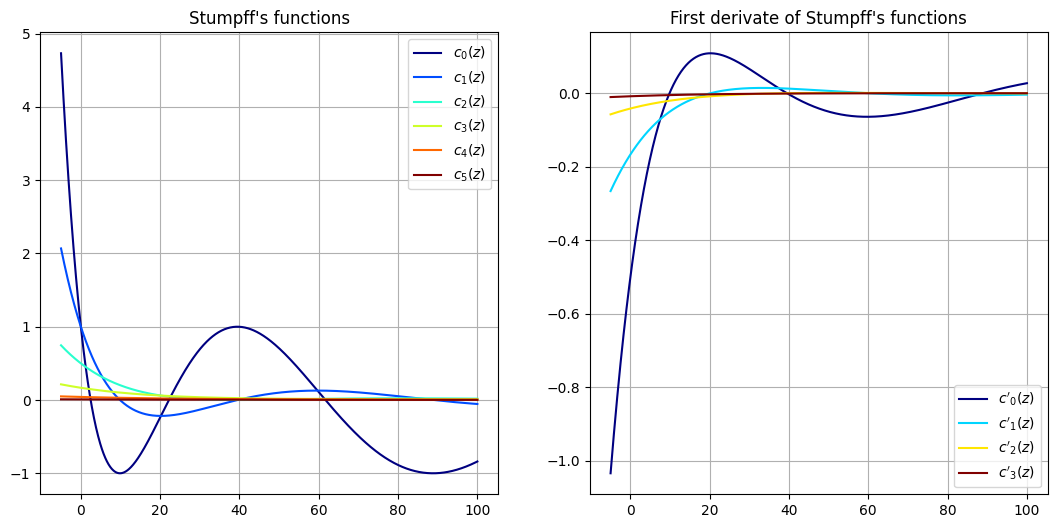

In [204]:
x = np.linspace(-5, 100, 1000)

fig, AX = plt.subplots(nrows=1, ncols=2, figsize=(13,6))

AX[0].set_title("Stumpff's functions")
for n, col in zip(range(0,6), cmaps.jet(np.linspace(0,1,6))):
  AX[0].plot(x, [c(z, n=n) for z in x], color=col,  label =f'$c_{n}(z)$')
AX[0].legend()
AX[0].grid()

AX[1].set_title("First derivate of Stumpff's functions")
for n, col in zip(range(0,4), cmaps.jet(np.linspace(0,1,4))):
  AX[1].plot(x, [c_prime(z, n=n) for z in x], color=col,  label =f"$c'_{n}(z)$")
AX[1].legend()
AX[1].grid()


## Universal Kepler's equation solver
The universal Kepler equation is $$ t(s)-t_0=r_0s + r_0 \dot r_0s^2 c_2(-2Cs^2)+(\mu+2r_0C)s^3c_3(-2Cs^2) $$ 
Implementing the Newton-Raphson's method gives $$ s_{n+1} = s_n +  \frac{\Delta t −[t(s_n) − t_0]}{r(s_n)} $$ as the recursive approximation, with starting point $s_0=0$ and the radius is expressed as $$ r(s) = r_0c_0
(−2Cs^2) + r_0 \dot r_0 s c_1(−2Cs^2) + \mu s^2c_2(−2Cs^2) $$ 
 
I found that the direct implementation of the Newton method is bad because the function becomes unstable after a certain point. To avoid this I used the Newton method implemented by the scipy package, which works fine. 

In [205]:
def t_(s, t0, r0, dr0, C, mu):
  '''Time from t0 as a function of s'''
  z = -2*C*s**2
  return t0 + r0*s+r0*dr0*s**2*c(z, n=2) + (mu + 2*r0*C)*s**3*c(z, n=3)

def r_(s, t0, r0, dr0, C, mu):
  '''Radius as a function of s'''
  z = -2*C*s**2
  return r0*c(z, n=0) + r0*dr0*s*c(z, n=1) + mu*s**2*c(z, n=2)

def UKE_solve(t, t0, r0, dr0, C, mu):
  s = 0
  if t==t0:
    return 0  #If t=t0, s=0 so there is no need to compute it 
  else: 
    f = lambda s, t0, r0, dr0, C, mu: t-t_(s, t0, r0, dr0, C, mu)
    f_prime = lambda s, t0, r0, dr0, C, mu: -r_(s, t0, r0, dr0, C, mu)
    s = newton(f, x0=0, fprime=f_prime, args=(t0,r0,dr0,C,mu), rtol=1e-14)
  return s

def UKE_solve_wrong(t, t0, r0, dr0, C, mu, atol=1e-12, rtol=1e-12):
  '''Direct implementation of the newton method'''
  s = 0
  delta_rel, error = 1, 1
  if t==t0:
    return 0  #If t=t0, s=0 so there is no need to compute it 
  else: 
    while delta_rel>rtol or error>atol: 
      error = (t-t_(s=s, t0=t0, r0=r0, dr0=dr0, C=C, mu=mu))#distance from zero 
      delta = error/r_(s=s, t0=t0, r0=r0, dr0=dr0, C=C, mu=mu)
      s = s + delta
      delta_rel = delta/s #Relative change in s'''
  return s


### Comparison between the two solvers
The black dotted line represent the direct function $t(s)$, while the others are the inverse functions found by the solvers (plotted as the direct function to make comparison easier). The direct implementation fails after a certain value of s.

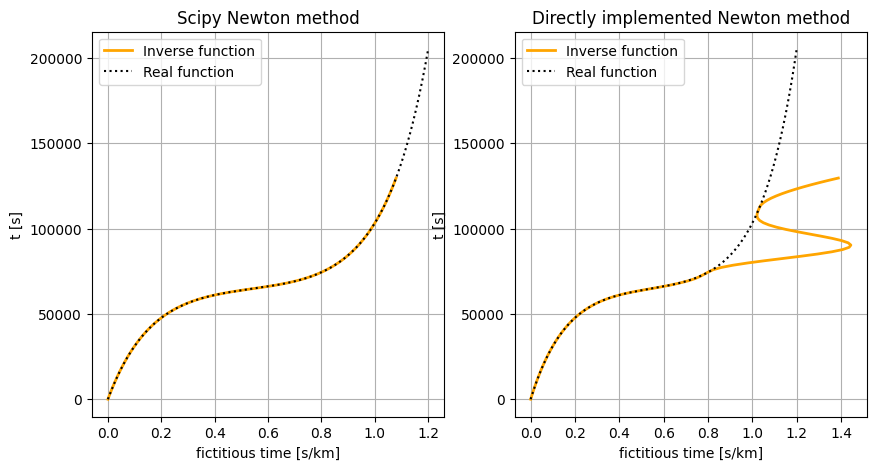

<Figure size 640x480 with 0 Axes>

In [206]:
r0 = np.linalg.norm(R0)
dr0 = np.dot(R0, V0)/r0         #dr0 is the radial component of the velocity
C = 0.5*np.dot(V0, V0) - GM/r0  #Constant of energy
T = np.linspace(0, 36*3600, 100)

s_list = [UKE_solve(t=t, t0=0.0, r0=r0, dr0=dr0, C=C, mu=GM) for t in T]
s_list_wrong = [UKE_solve_wrong(t=t, t0=0.0, r0=r0, dr0=dr0, C=C, mu=GM) for t in T]

# True function
S = np.linspace(0,1.2, 1000)
t_list = [t_(s, 0, r0, dr0, C, GM) for s in S]

fig, AX = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
AX[0].set_title('Scipy Newton method')
AX[0].plot(s_list, T, color='orange', lw=2, label='Inverse function')

AX[1].set_title('Directly implemented Newton method')
AX[1].plot(s_list_wrong, T, color='orange', lw=2, label='Inverse function')

AX[0].plot(S, t_list, ls='dotted', color='k', label='Real function')
AX[1].plot(S, t_list, ls='dotted', color='k', label='Real function')

AX[0].set_xlabel('fictitious time [s/km]')
AX[0].set_ylabel('t [s]')
AX[1].set_xlabel('fictitious time [s/km]')
AX[1].set_ylabel('t [s]')
AX[0].legend()
AX[0].grid()
AX[1].legend()
AX[1].grid()

plt.show()
plt.tight_layout()


## Venus Flyby 
The position and velocity at a given parameter $s$ are given by the universal Lagrange coefficients matrix
$$ \begin{pmatrix} \mathbf r \\ \mathbf{ \dot r} \end{pmatrix} = \begin{pmatrix} F & G \\ \dot F & \dot G \end{pmatrix} \begin{pmatrix} \mathbf r_0 \\ \mathbf{ \dot r}_0 \end{pmatrix} $$
 with

$$ F = 1 − \frac{\mu}{r_0}s^2c_2(−2Cs^2) $$
$$ G = r_0s c_1(−2Cs^2) + r_0 \dot r_0 s^2c_2(−2Cs^2) $$
$$ \dot F = − \frac{μ}{r(s)r_0}s c_1(−2Cs^2) $$
$$ \dot G = \frac{r_0}{r(s)}c_0(-2Cs^2) + \frac{r_0 \dot r_0}{r(s)}sc_1(−2Cs^2) $$ 

In [207]:
R0 = np.array([-267733.084163, 199426.194677, 254709.414665]) # I use the upper case to indicate a vector
V0 = np.array([4.168950, -2.598877, -3.925639])
GM = 324859.2139518842890 


def ULM(s, r0, dr0, C, mu):
  '''Universal Lagrange Matrix'''
  z = -2*C*s**2
  r = r_(s=s, t0=0, r0=r0, dr0=dr0, C=C, mu=mu)

  F = 1.0 - mu/r0*s**2*c(z, n=2)
  G = r0*s*c(z, n=1) + r0*dr0*s**2*c(z, n=2)
  dF = -mu/(r*r0)*s*c(z, n=1)
  dG = r0/r*c(z, n=0) + r0*dr0/r*s*c(z, n=1)
  return np.array([F, G, dF, dG])

def get_orbit(T, mu, R0, V0):
  '''Get position and velocity during an orbit'''
  r0 = np.linalg.norm(R0)
  dr0 = np.dot(R0, V0)/r0         #dr0 is the radial component of the velocity
  C = 0.5*np.dot(V0, V0) - mu/r0  #Constant of energy
 
  s_list = [UKE_solve(t=t, t0=0.0, r0=r0, dr0=dr0, C=C, mu=mu) for t in T] #List that contains the fictitiuos times

  ULMs = np.array([ULM(s=s, r0=r0, dr0=dr0, C=C, mu=mu) for s in s_list])
  R = np.array([ulm[0]*R0+ulm[1]*V0 for ulm in ULMs])
  V = np.array([ulm[2]*R0+ulm[3]*V0 for ulm in ULMs])
  return R, V


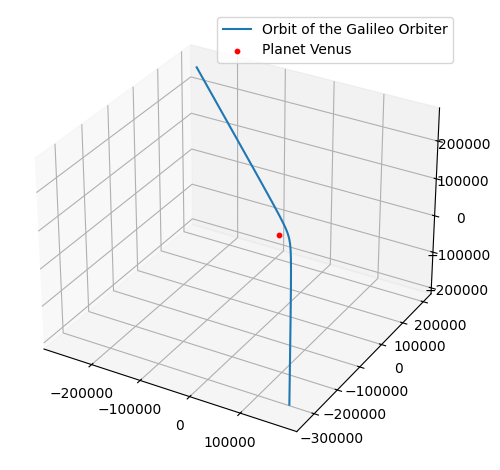

In [208]:
T = np.linspace(0, 36*3600, 1000)

R, V = get_orbit(T, GM, R0, V0)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(R[:,0], R[:,1], R[:,2], label='Orbit of the Galileo Orbiter')
ax.scatter(0,0,0, marker='o', color='red', s=10, label='Planet Venus')
ax.legend()
plt.tight_layout()
plt.show()


In [209]:
R, V = get_orbit(T=[36*3600], mu=GM, R0=R0, V0=V0)
print('The final dynamical state is :')
print('R: ', R[0], '[km]')
print('V: ', V[0], '[km/s]' )


The final dynamical state is :
R:  [ 176956.9297027  -334433.44069937 -184558.85545376] [km]
V:  [ 2.36979447 -5.24495423 -2.53289844] [km/s]


## Universal Lambert's Equation
The Universal Lambert's equation gives the energy constant needed to orbit from $r_0$ to $r$ in a given time:
$$ t − t_0 = A \sqrt{s^2c_2 (z)} + \mu s^3c_3 (z) $$
$$ A = \frac{\sqrt{r_0r_t}\sin \Delta f}{\sqrt{1-\cos \Delta f}} $$
$$ s^2 = \frac{1}{\mu c_2(z)}\left[r_0+r_t-A\frac{c_1(z)}{\sqrt{c_2(z)}}\right] $$
The first equation can be combined with the third to find $z$ and then, using $z=-2Cs^2$, the constant of energy will be found.  
To do this, I have implemented the Newton-Raphson method $x_{n+1} = x_n-\frac{f(x_n)}{f'(x_n)}$, where the function to found the root of is $t(z)-t0-\Delta t$. The derivative of $t(z)-t_0$ w.r.t $z$ is $$ \frac{A^2}{8\mu s}+ \frac{3sc_3(z)}{2c_2(z)}\left( \frac{A\sqrt{c_2(z)}}{4}-\mu s^2 c'_2(z)\right) + \mu s^3 c'_3(z) $$ The chosen starting point is $z=0$.

After obtaining $C$, the initial velocity can be found by inverting $\mathbf r = F \mathbf r_0 + G \mathbf{\dot r}_0$ by using 
$$ F = 1 − \frac{\mu}{r_0}s^2c_2(z)$$
$$ G = t − t_0 − \mu s^3 c_3 (z) $$

In [210]:
def solve_Lambert(R0, R, Dt, mu, tol=1e-12):
  r0 = np.linalg.norm(R0)
  r = np.linalg.norm(R)
  Df = np.arccos(np.dot(R, R0)/(r*r0))
  A = (r0*r)**0.5*np.sin(Df)/(1-np.cos(Df))**0.5

  f = lambda z, s: A*(s**2*c(z, n=2))**0.5 + mu*s**3*c(z, n=3)
  s_ = lambda z: ((r0+r-A*c(z, n=1)/(c(z, n=2))**0.5)/(mu*c(z, n=2)))**0.5
  f_prime = lambda z, s: A**2/(8*mu*s) + 3*s*c(z, n=3)/(2*c(z, n=2))*(A/4*c(z, n=2)**0.5 - mu*s*c_prime(z, n=2)) + mu*s**3*c_prime(z, n=3)

  z=0
  delta_rel = 1
  if f(z, s_(z))==Dt:
    #If the problem is alredy solved for z=0, the orbit is a parabola
    C=0
    s = s_(0)
  else :
    while np.abs(delta_rel)>tol:
      s = s_(z)
      delta = (f(z,s)-Dt)/f_prime(z,s)
      z = z-delta
      delta_rel = delta/z

    # At the end, compute the value of C
    s = s_(z)
    C = -z/(2*s**2)
  
  F = 1.0- mu/r0*s**2*c(z, n=2)
  G = Dt - mu*s**3*c(z, n=3)

  V0 = (R-F*R0)/G
  
  return V0


In [211]:
R = np.array([177071.935393, -334448.764629, -184024.725921])
V0 = Lambert_Solve(R0, R, 36*3600, GM)
print(V0)


[ 3.13466068 -4.3618355  -3.1379475 ]
